# Восстановление золота из руды

В данной работе будет необходимо построить модель машинного обучения, которая предскажет коэффициент восстановления золота из золотосодержащей руды.

В работе используем данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Описание проекта

Данные находятся в трёх файлах:
-	gold_recovery_train_new.csv — обучающая выборка;
-	gold_recovery_test_new.csv — тестовая выборка;
-	gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 

Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, надо проверить их на корректность.

Нам нужно:

Подготовить данные
Провести исследовательский анализ данных
Построить и обучить модель
Описание данных

Для полного понимания о данной работе для начала познакомимся с технологическим процессом и познакомимся с каждой стадией:

1. Флотация:

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка:

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

Технологический процесс:

Rougher feed — исходное сырье
Rougher additions (или reagent additions) — флотационные реагенты:
 1. Xanthate - ксантогенат (промотер, или активатор флотации)
 2. Sulphate - сульфат (на данном производстве сульфид натрия)
 3. Depressant -  депрессант (силикат натрия)
Rougher process (англ. «грубый процесс») — флотация
Rougher tails — отвальные хвосты
Float banks — флотационная установка
Cleaner process — очистка
Rougher Au — черновой концентрат золота
Final Au — финальный концентрат золота
Параметры этапов:

air amount — объём воздуха
fluid levels — уровень жидкости
feed size — размер гранул сырья
feed rate — скорость подачи
Значения признаков в наших данных

Описываются они так:

[этап].[тип_параметра].[название_параметра]

значения для блока [этап]:

rougher — флотация
primary_cleaner — первичная очистка
secondary_cleaner — вторичная очистка
final — финальные характеристики
значения для блока [тип_параметра]:

input — параметры сырья
output — параметры продукта
state — параметры, характеризующие текущее состояние этапа
calculation — расчётные характеристики

## 1. Подготовка данных

### 1.1. Откроем файлы и изучим их

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
sns.set()

import warnings
warnings.filterwarnings('ignore')

Импортируем файлы с данными и запишим их в переменные.

In [2]:
# data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col = 'date')
# data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col = 'date')
# data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col = 'date')
data_train = pd.read_csv('/Users/Mikalai/Documents/Data Science/Сборный проект_2/gold_recovery_train_new.csv')
data_test = pd.read_csv('/Users/Mikalai/Documents/Data Science/Сборный проект_2/gold_recovery_test_new.csv')
data_full = pd.read_csv('/Users/Mikalai/Documents/Data Science/Сборный проект_2/gold_recovery_full_new.csv')

Рассмотрим датафрейм data_full

In [3]:
data_full.shape

(19439, 87)

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [5]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
data_full.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Рассмотрим датафрейм data_train

In [7]:
data_train.shape

(14149, 87)

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [9]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
data_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Рассмотрим датафрейм data_test

In [11]:
data_test.shape

(5290, 53)

In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [13]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [14]:
data_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

##### Вывод

По итогам ознакомления с данными имеются: 
- датасет full - содержащий весь объем данных, 
- train и test - это разбитый full для обучающей и тестовой выборки. 

Все данные типа float, кроме колонки date - она типа object.

Обучающая и полные выборки имеют одинаковое количесво признаков, в тестовой выборке некоторые признаки отсутвуют. 

Во всех выборках имеются пропуски. При этом видим, что данные содержат различное количество пропущенных значений, меняющееся от поля к полю.

Набор данных содержит атрибуты, описывающие 4 этапа технологического процесса получения золота из руды:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

### 1.2. Проверим формулу вычисления эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака

Расчитаем эффективность обогащения золота по формуле

In [15]:
# Создадим таблицу с данными по содержанию золота на этапах технологического процесса: 
data_train_for_calс = data_train.dropna()

data_train_au = data_train_for_calс[['rougher.output.concentrate_au', 
                        'rougher.input.feed_au', 
                        'rougher.output.tail_au',
                        'rougher.output.recovery']]

# Создадим переменные содержания зоолота во фракциях
с = data_train_au['rougher.output.concentrate_au'] # C — доля золота в концентрате после флотации/очистки;
f = data_train_au['rougher.input.feed_au'] # F — доля золота в сырье/концентрате до флотации/очистки;
t = data_train_au['rougher.output.tail_au'] # T — доля золота в отвальных хвостах после флотации/очистки.

# Расчитаем эффективность обогащения золота по формуле и добавим значения в новый столбец
data_train_au['recovery_calculation'] = (с * (f - t)) / (f * (с - t)) * 100

Выведем результат на экран

In [16]:
data_train_au.head(5)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,recovery_calculation
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


Эффективность обогащения посчитана успешно.

Следующий этап - понять, насколько расчётное значение этого показателя будет отличаться от исходного. Для этого рассчитаем среднюю абсолютную ошибку - MAE.

В отличие от простой суммы отклонений расчитанного значения от реального, где отрицательные значения были бы компенсированы положительными, MAE считает отклонения по модулю, следовательно, результаты не будут искажены.

In [17]:
print('МАЕ между расчетными данными и значением признака:', 
      mean_absolute_error(data_train_au['recovery_calculation'], data_train_au['rougher.output.recovery']))

МАЕ между расчетными данными и значением признака: 9.82970122149377e-15


##### Вывод

MAE эффективности обогащения 9.82970122149377e-15 - это очень маленькое значение. 

Это говорит о том, что изначально рассчитанная эффективность обогащения получена верно.

### 1.3. Проанализируем признаки, недоступные в тестовой выборке

Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [18]:
print('Количество наблюдений и признаков полных данных', data_full.shape)
#print('Признаки полных данных')
#print(data_full.columns)
print()
print('Количество наблюдений и признаков в тренировочной выборке', data_train.shape)
#print('Признаки тренировочных данных')
#print(data_train.columns)
print()
print('Количество наблюдений и признаков тестовых данных', data_test.shape)
#print('Признаки тестовых данных')
#print(data_test.columns)

Количество наблюдений и признаков полных данных (19439, 87)

Количество наблюдений и признаков в тренировочной выборке (14149, 87)

Количество наблюдений и признаков тестовых данных (5290, 53)


Посчитаем сколько у нас недоступных признаков в тестовой выборке.

In [19]:
print('\nКоличество недостающих признаков:', data_train.shape[1] - data_test.shape[1])


Количество недостающих признаков: 34


Выясним, какие признаки из тренировочной выборки не попали в тестовую.

In [20]:
print('\nСписок недостающих признаков\n')
data_train.columns.drop(data_test.columns)


Список недостающих признаков



Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

##### Вывод
В тестовой выборке отсутствуют признаки (34 шт), которые относятся к типу параметра "output - "Параметры продукта", calculation - "Расчётные характеристики":

Этап final - финальные характеристики

Тип параметра output - параметры продукта:
- 'final.output.concentrate_ag'
- 'final.output.concentrate_pb'                         
- 'final.output.concentrate_sol'                          
- 'final.output.concentrate_au'                         
- 'final.output.recovery'                          
- 'final.output.tail_ag' 
- 'final.output.tail_pb'
- 'final.output.tail_sol' 
- 'final.output.tail_au' 
                                                 
Этап primary_cleaner - первичная очистка:

Тип параметра output - параметры продукта:
- 'primary_cleaner.output.concentrate_ag'
- 'primary_cleaner.output.concentrate_pb'
- 'primary_cleaner.output.concentrate_sol'
- 'primary_cleaner.output.concentrate_au'
- 'primary_cleaner.output.tail_ag' 
- 'primary_cleaner.output.tail_pb'
- 'primary_cleaner.output.tail_sol' 
- 'primary_cleaner.output.tail_au'

Этап rougher - флотация:

Тип параметра calculation - расчётные характеристики:
- 'rougher.calculation.sulfate_to_au_concentrate'
- 'rougher.calculation.floatbank10_sulfate_to_au_feed'
- 'rougher.calculation.floatbank11_sulfate_to_au_feed'
- 'rougher.calculation.au_pb_ratio'

Тип параметра output - параметры продукта:
- 'rougher.output.concentrate_ag',
- 'rougher.output.concentrate_pb' 
- 'rougher.output.concentrate_sol'
- 'rougher.output.concentrate_au' 
- 'rougher.output.recovery'
- 'rougher.output.tail_ag' 
- 'rougher.output.tail_pb'
- 'rougher.output.tail_sol' 
- 'rougher.output.tail_au'

Этап secondary_cleaner - вторичная очистка:

Тип параметра output - параметры продукта:
- 'secondary_cleaner.output.tail_ag' 
- 'secondary_cleaner.output.tail_pb'
- 'secondary_cleaner.output.tail_sol' 
- 'secondary_cleaner.output.tail_au'

### 1.4. Проведем предобработку данных

Добавим в тестовую выборку целевые признаки, которые надо спрогнозировать: rougher.output.recovery final.output.recovery

Так как в условиия проекта сказано, что соседние по времени параметры часто похожи, то заполним пропуски в данных ближайшими значениями методом ffill.

In [21]:
# <Сначала заполним пропуски только у features>
data_full_target_rougher = data_full['rougher.output.recovery']
data_full_target_final = data_full['final.output.recovery']
data_full_features = data_full.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
data_full_features.ffill(axis=0,inplace=True)

# <Затем добавим их обратно и сбросим пропуски у целевых>
data_full_features['rougher.output.recovery'] = data_full_target_rougher
data_full_features['final.output.recovery'] = data_full_target_final
data_full = data_full_features.dropna()
data_full.reset_index(inplace=True, drop = True)

In [22]:
# <Сделаем также на обучающей выборке>
data_train_target_rougher = data_train['rougher.output.recovery']
data_train_target_final = data_train['final.output.recovery']
data_train_features = data_train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
data_train_features.ffill(axis=0,inplace=True)
data_train_features['rougher.output.recovery'] = data_train_target_rougher
data_train_features['final.output.recovery'] = data_train_target_final
data_train = data_train_features.dropna()
data_train.reset_index(inplace=True, drop = True)

In [23]:
# <На тестовой выборке>
data_test = data_test.ffill(axis=0)

Добавим в тестовую выборку данные целевых признаков из полного датасета:

In [24]:
data_test = data_test.merge(right = data_full[['final.output.recovery','date']], how='left', on='date')
data_test = data_test.merge(right = data_full[['rougher.output.recovery','date']], how='left', on='date')
data_test = data_test.dropna()

Удалим столбец date, так как для обучения модели он не понадобится

In [25]:
data_test = data_test.drop(['date'], axis=1)
data_train = data_train.drop(['date'], axis=1)

In [26]:
data_train.duplicated().sum()

0

In [27]:
data_test.duplicated().sum()

0

#### Вывод

- Дубликатов в обучающей и тестовой выборках нет.
- Пропуски в данных в обучающей и тестовой выборках заполнены с помощью метода ffill. Замена пропущенных значений с помощью метода ffill предполагает замену пропущенных значений на значения ближайших к нему соседей. Этот способ максимально полно соответствует условиям проекта в части схожести соседтствующих по дате параметрам.

## 2. Анализ данных

### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки 

Посмотрим, как меняется концентрация золота (Au) на различных этапах очистки

In [28]:
print("Концентрация золота (Au) после флотации")
print(data_full['rougher.output.concentrate_au'].median())
print()
print("Концентрация золота (Au) после первого этапа очистки")
print(data_full['primary_cleaner.output.concentrate_au'].median())
print()
print("Финальный концентрат золота (Au) после второго этапа очистки")
print(data_full['final.output.concentrate_au'].median())

Концентрация золота (Au) после флотации
20.280214025891475

Концентрация золота (Au) после первого этапа очистки
32.841295480233306

Финальный концентрат золота (Au) после второго этапа очистки
45.01124391455689


Посмотрим, как меняется концентрация серебра (Ag) на различных этапах очистки

In [29]:
print("Концентрация серебра (Ag) после флотации")
print(data_full['rougher.output.concentrate_ag'].median())
print()
print("Концентрация серебра (Ag) после первого этапа очистки")
print(data_full['primary_cleaner.output.concentrate_ag'].median())
print()
print("Финальный концентрат серебра (Ag) после второго этапа очистки")
print(data_full['final.output.concentrate_ag'].median())

Концентрация серебра (Ag) после флотации
12.098114967346191

Концентрация серебра (Ag) после первого этапа очистки
8.507297972365805

Финальный концентрат серебра (Ag) после второго этапа очистки
5.066039118467836


Посмотрим, как меняется концентрация свинца (Pb) на различных этапах очистки

In [30]:
print("Концентрация свинца (Pb) после флотации")
print(data_full['rougher.output.concentrate_pb'].median())
print()
print("Концентрация свинца (Pb) после первого этапа очистки")
print(data_full['primary_cleaner.output.concentrate_pb'].median())
print()
print("Финальный концентрат свинца (Pb) после второго этапа очистки")
print(data_full['final.output.concentrate_pb'].median())

Концентрация свинца (Pb) после флотации
7.742580079502529

Концентрация свинца (Pb) после первого этапа очистки
10.142270415359071

Финальный концентрат свинца (Pb) после второго этапа очистки
10.10226350598865


Построим графики изменения концентрации металлов на разных этапах очистки.

In [31]:
# <Создадим датафреймы, которые будем использовать для исследования изменений концентрации металлов>
concentrate_au = data_full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
concentrate_ag = data_full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
concentrate_pb = data_full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

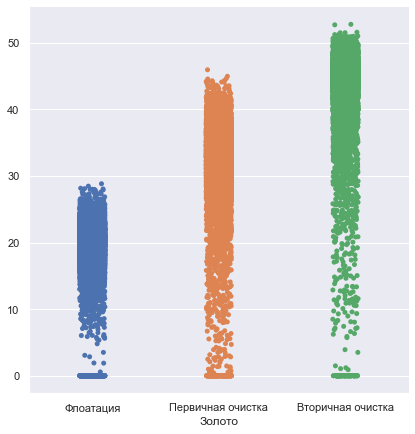

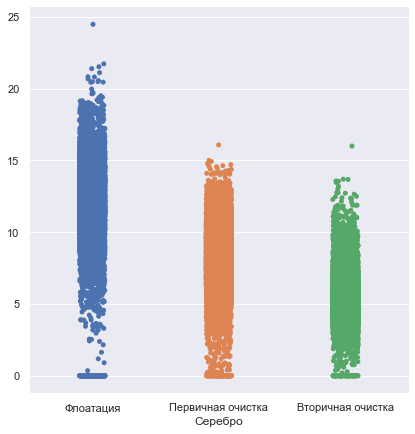

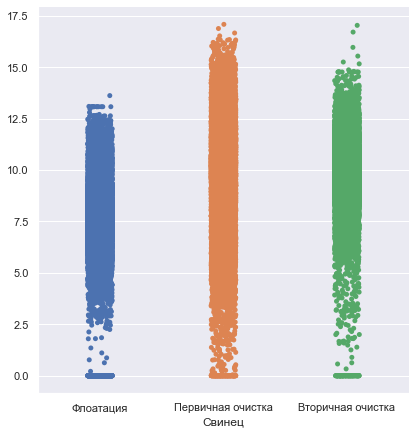

In [32]:
g = sns.catplot(data=concentrate_au, height = 6)
g.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'])
g.set_axis_labels('Золото')
r = sns.catplot(data=concentrate_ag, height = 6)
r.set_axis_labels('Серебро')
r.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'])
y = sns.catplot(data=concentrate_pb, height = 6)
y.set_axis_labels('Свинец')
y.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'])

##### Вывод:

Концентрация металлов в процессе очистки изменяется:
- Концентрация золота повышается
- Концентрация серебра снижается
- Концентрация свинца примерно одинакова

Так же заметно разделение золота от других металлов

### 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Построим график распределения размеров гранул сырья на обучающей и тестовой выборках

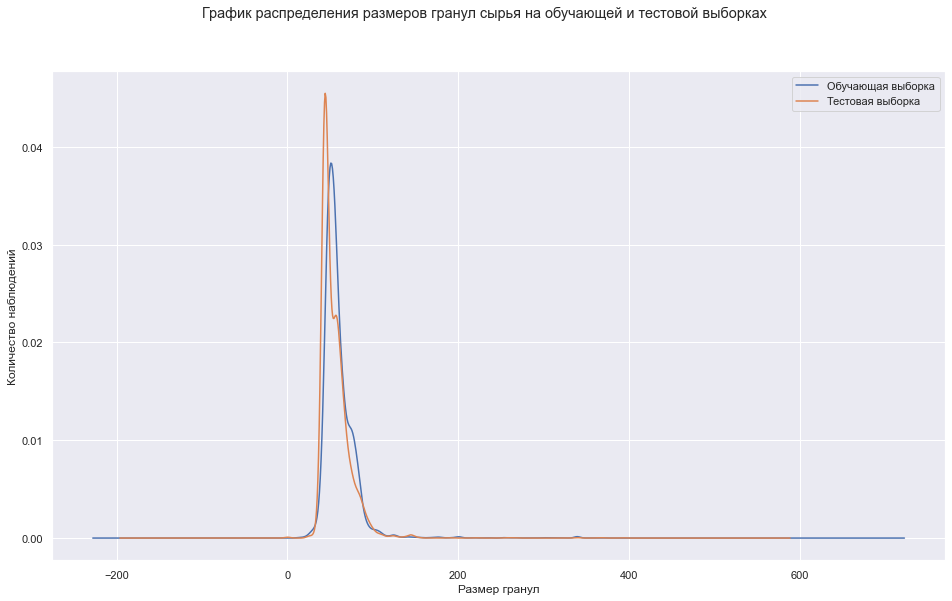

In [33]:
data_train['rougher.input.feed_size'].plot.kde(legend = True, label = 'Обучающая выборка', figsize = (16, 9))
data_test['rougher.input.feed_size'].plot.kde(legend = True, label = 'Тестовая выборка', figsize = (16, 9))
plt.suptitle("График распределения размеров гранул сырья на обучающей и тестовой выборках")
plt.xlabel("Размер гранул")
plt.ylabel("Количество наблюдений")
plt.show()

Вывод

Из графика видно, что на обучающей и тестовой выборках размер гранул на входе этапа флотации можно считать одинаковым

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

#### Сырье

<AxesSubplot:ylabel='Density'>

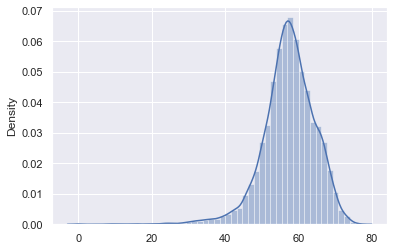

In [34]:
sum_concentrat_rougher_input = data_full['rougher.input.feed_ag']+ \
data_full['rougher.input.feed_pb']+\
data_full['rougher.input.feed_au']+\
data_full['rougher.input.feed_sol']
sns.distplot(sum_concentrat_rougher_input)

#### Черновой концентрат

<AxesSubplot:ylabel='Density'>

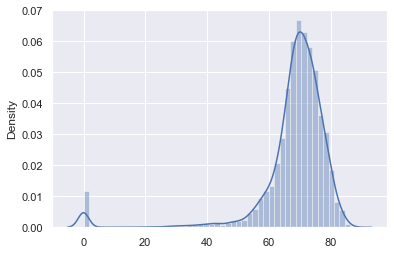

In [35]:
sum_concentrat_rougher_output = data_full['rougher.output.concentrate_ag']+ \
data_full['rougher.output.concentrate_pb']+\
data_full['rougher.output.concentrate_au']+\
data_full['rougher.output.concentrate_sol']
sns.distplot(sum_concentrat_rougher_output)

#### Финальный концентрат

<AxesSubplot:ylabel='Density'>

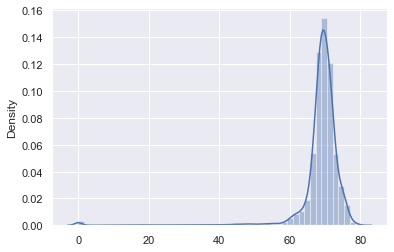

In [36]:
sum_concentrat_final_output = data_full['final.output.concentrate_ag']+ \
data_full['final.output.concentrate_pb']+\
data_full['final.output.concentrate_au']+\
data_full['final.output.concentrate_sol']
sns.distplot(sum_concentrat_final_output)

Видим, что на всех стадиях очистки имеются нулевые значения концентрации веществ - похоже на аномалии, так как не может быть нулевая концентрация веществ в какой-либо стадии технологического процесса.

Отфильтруем нулевые значения

In [37]:
data_train = data_train.loc[data_train['rougher.input.feed_au'] > 0.1]
data_test = data_test.loc[data_test['rougher.input.feed_au'] > 0.1]

#### Вывод

Мы проанализировали как меняется концентрация металлов на разных этапах очистки, и пришли к выводу что доля золота увелчивается, доля серебра уменьшается, и доля свинца уменьшается тоже, хотя по графику сразу и не скажешь.

Мы оценили распределения размеров гранул на обучающей и тестовой выборке и пришли к выводу что они различаются не слишком сильно, и это не слишком повлияет на оценку модели.

Мы исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Пришли к выводу что в данных есть аномалии и избавились от них.

## 3. Модель

### 3.1. Напишем функцию для вычисления итоговой sMAPE.

Напишем фунцию для вычисления sMAPE

In [38]:
def sMAPE(y_true, y_pred):
    """Функция на вход принимает вектор истинных и предсказанных значений и вычисляет метрику sMAPE"""
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

Напишем функцию вычисления Итоговой sMAPE

In [39]:
def func_total_sMAPE(sMAPE_rougher, sMAPE_final):
    total_sMAPE = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    return total_sMAPE

In [40]:
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)

Удалим в обучающей выборке признаки, которых нет в тестовой выборке

In [41]:
print('\nСписок признаков для удаления в обучающей выборке\n')
data_train.columns.drop(data_test.columns)


Список признаков для удаления в обучающей выборке



Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.tail_ag',
       'rougher.outp

In [42]:
data_train = data_train.drop(['final.output.concentrate_ag', 
                         'final.output.concentrate_pb',
                         'final.output.concentrate_sol', 
                         'final.output.concentrate_au',
                         'final.output.tail_ag', 
                         'final.output.tail_pb',
                         'final.output.tail_sol', 
                         'final.output.tail_au',
                         'primary_cleaner.output.concentrate_ag',
                         'primary_cleaner.output.concentrate_pb',
                         'primary_cleaner.output.concentrate_sol',
                         'primary_cleaner.output.concentrate_au',
                         'primary_cleaner.output.tail_ag', 
                         'primary_cleaner.output.tail_pb',
                         'primary_cleaner.output.tail_sol', 
                         'primary_cleaner.output.tail_au',
                         'rougher.calculation.sulfate_to_au_concentrate',
                         'rougher.calculation.floatbank10_sulfate_to_au_feed',
                         'rougher.calculation.floatbank11_sulfate_to_au_feed',
                         'rougher.calculation.au_pb_ratio',
                         'rougher.output.concentrate_ag',
                         'rougher.output.concentrate_pb', 
                         'rougher.output.concentrate_sol',
                         'rougher.output.concentrate_au',
                         'rougher.output.tail_ag', 
                         'rougher.output.tail_pb',
                         'rougher.output.tail_sol', 
                         'rougher.output.tail_au',
                         'secondary_cleaner.output.tail_ag', 
                         'secondary_cleaner.output.tail_pb',
                         'secondary_cleaner.output.tail_sol', 
                         'secondary_cleaner.output.tail_au'], axis = 1)
#data_train = data_train.fillna(method = 'ffill')
data_train.shape

(14144, 54)

In [43]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14144 entries, 0 to 14148
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14144 non-null  float64
 1   primary_cleaner.input.depressant            14144 non-null  float64
 2   primary_cleaner.input.feed_size             14144 non-null  float64
 3   primary_cleaner.input.xanthate              14144 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14144 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14144 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14144 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14144 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14144 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    14144 non-null  float64
 10  primary_cl

In [44]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64
 10  primary_clea

### 3.2. Обучим разные модели и оцените их качество кросс-валидацией

#### 3.2.1. Спрогнозируем эффективность обогащения чернового концентрата rougher.output.recovery

Разделим обучающую выборку на целевой признак и признаки

In [45]:
target = data_train['rougher.output.recovery'] # Целевой признак
features = data_train.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки


# Разделим выборку датасет train на тренировочную и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)

# проверим корректность разделения
print('Размер выборки до разделения на целевой признак и признаки', data_train.shape)
print('Размер таблицы целевого признака', target_train.shape)
print('Размер таблицы признаков', features_train.shape)
print('Размер таблицы целевого признака валидация', target_valid.shape)
print('Размер таблицы признаков валидации', features_valid.shape)

Размер выборки до разделения на целевой признак и признаки (14144, 54)
Размер таблицы целевого признака (10608,)
Размер таблицы признаков (10608, 52)
Размер таблицы целевого признака валидация (3536,)
Размер таблицы признаков валидации (3536, 52)


Подберем гиперпараметры и обучим модель Решающее дерево для регрессии DecisionTreeRegressor 

In [46]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'criterion': ['mse', 'mae'],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10]
}

# <дерево принятия решений к которому будем подбирать параметры>
estimator = DecisionTreeRegressor(random_state = 12345)

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, cv=4, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Решающее дерево ")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Результат для модели Решающее дерево 

Лучшие параметры: {'min_samples_split': 10, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'mse'}

Лучший результат sMAPE_rougher: 11.3937


Подберем гиперпараметры и обучим модель Случайный лес для регрессии RandomForestRegressor

In [47]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'n_estimators': list(np.arange(2, 101, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# <случайный лес к которому будем подбирать параметры>
estimator = RandomForestRegressor(random_state = 12345)

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, cv=4, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Случайный лес")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Результат для модели Случайный лес

Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 5, 'max_leaf_nodes': 20, 'max_features': 'auto', 'max_depth': 2, 'bootstrap': False}

Лучший результат sMAPE_rougher: 11.3937


Подберем гиперпараметры и обучим модель Линейная регрессия LinearRegression

In [48]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {'fit_intercept': [True, False], 
                  'normalize': [True, False]                  
}

# <случайный лес к которому будем подбирать параметры>
estimator = LinearRegression()

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Линейная регрессия")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Результат для модели Линейная регрессия

Лучшие параметры: {'normalize': True, 'fit_intercept': False}

Лучший результат sMAPE_rougher: 10.5453


Подберем лучшую модель для прогноза обогащения чернового концентрата rougher.output.recovery

In [49]:
# DecisionTreeRegressor
print()
print('Расчеты на модели DecisionTreeRegressor - Дерево решений для регрессии на черновом концентрате')

model_tree = DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='sqrt',
                      max_leaf_nodes=50, min_samples_split=10,
                      random_state=12345)
'min_samples_split': 10, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'mse'
# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_tree, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели DecisionTreeRegressor by cross_val_score: {round(score, 4)}')

# Fit - predict
model_tree.fit(features_train, target_train)
predictions_rougher = model_tree.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели DecisionTreeRegressor by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели DecisionTreeRegressor - Дерево решений для регрессии на черновом концентрате
Метрика sMAPE на модели DecisionTreeRegressor by cross_val_score: 12.0592
Метрика sMAPE на модели DecisionTreeRegressor by fit-predict: 9.9877


In [50]:
# RandomForestRegressor
print()
print('Расчеты на модели RandomForestRegressor - Случаный лес для регрессии на черновом концентрате')
model_forest = RandomForestRegressor(max_depth=None, n_estimators=44, min_samples_split=10, max_leaf_nodes=10, 
                            max_features='auto', bootstrap=False, random_state=12345)
                        
# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_forest, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели RandomForestRegressor by cross_val_score: {round(score, 4)}')

# Fit - predict
model_forest.fit(features_train, target_train)
predictions_rougher = model_forest.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели RandomForestRegressor by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели RandomForestRegressor - Случаный лес для регрессии на черновом концентрате
Метрика sMAPE на модели RandomForestRegressor by cross_val_score: 11.5931
Метрика sMAPE на модели RandomForestRegressor by fit-predict: 10.3184


In [51]:
# LinearRegression
print()
print('Расчеты на модели LinearRegression - Линейная регрессия на черновом концентрате')

model_linear = LinearRegression(normalize=True, fit_intercept=False)

# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_linear, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели LinearRegression by cross_val_score: {round(score, 4)}')

# Fit - predict
model_linear.fit(features_train, target_train)
predictions_rougher = model_linear.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели LinearRegression by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели LinearRegression - Линейная регрессия на черновом концентрате
Метрика sMAPE на модели LinearRegression by cross_val_score: 13.0091
Метрика sMAPE на модели LinearRegression by fit-predict: 9.9024


#### Лучшая модель Случаный лес для регрессии - RandomForestRegressor 

Проверим лучшую модель на тестовой выборке

In [52]:
target_test = data_test['rougher.output.recovery'] # Целевой признак
features_test = data_test.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки

target_train = data_train['rougher.output.recovery'] # Целевой признак
features_train = data_train.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки
print('Размер target_test_rougher', target_test.shape)
print('Размер features_test_rougher', features_test.shape)
print('Размер target_train_rougher', target_train.shape)
print('Размер features_train_rougher', features_train.shape)

Размер target_test_rougher (5290,)
Размер features_test_rougher (5290, 52)
Размер target_train_rougher (14144,)
Размер features_train_rougher (14144, 52)


Сделаем предсказания на тестовых признаках и вычислим метрику sMAPE rougher.output.recovery

In [53]:
predicted_test = model_forest.predict(features_test)
sMAPE_rougher = sMAPE(target_test, predicted_test)
print('Метрика sMAPE_rougher:' , sMAPE_rougher)

Метрика sMAPE_rougher: 11.46019434781976


In [54]:
predicted_rougher_constant = pd.Series(target_train.median(), index = target_test.index)
sMAPE_rougher_constant = sMAPE(target_test, predicted_rougher_constant)
print('Константная модель Метрика sMAPE rougher:', sMAPE_rougher_constant)

Константная модель Метрика sMAPE rougher: 8.628662163379941


#### Вывод 

Качество модели немного хуже, чем метрика константной модели

#### 3.2.2. Спрогнозируем эффективность обогащения финального концентрата final.output.recovery

Разделим обучающую выборку на целевой признак и признаки

In [55]:
target = data_train['final.output.recovery'] # Целевой признак
features = data_train.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки


# Разделим выборку датасет train на тренировочную и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)

In [56]:
# проверим корректность разделения
print('Размер выборки до разделения на целевой признак и признаки', data_train.shape)
print('Размер таблицы целевого признака', target_train.shape)
print('Размер таблицы признаков', features_train.shape)
print('Размер таблицы целевого признака валидация', target_valid.shape)
print('Размер таблицы признаков валидации', features_valid.shape)

Размер выборки до разделения на целевой признак и признаки (14144, 54)
Размер таблицы целевого признака (10608,)
Размер таблицы признаков (10608, 52)
Размер таблицы целевого признака валидация (3536,)
Размер таблицы признаков валидации (3536, 52)


Подберем гиперпараметры и обучим модель Решающее дерево для регрессии DecisionTreeRegressor 

In [57]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'criterion': ['mse', 'mae'],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10]
}

# <дерево принятия решений к которому будем подбирать параметры>
estimator = DecisionTreeRegressor(random_state = 12345)

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, cv=4, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Решающее дерево ")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Результат для модели Решающее дерево 

Лучшие параметры: {'min_samples_split': 5, 'max_leaf_nodes': 30, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'mse'}

Лучший результат sMAPE_rougher: 9.3052


Подберем гиперпараметры и обучим модель Случайный лес для регрессии RandomForestRegressor

In [58]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'n_estimators': list(np.arange(2, 101, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# <случайный лес к которому будем подбирать параметры>
estimator = RandomForestRegressor(random_state = 12345)

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, cv=4, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Случайный лес")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Результат для модели Случайный лес

Лучшие параметры: {'n_estimators': 88, 'min_samples_split': 10, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 10, 'bootstrap': False}

Лучший результат sMAPE_rougher: 9.5293


Подберем гиперпараметры и обучим модель Линейная регрессия LinearRegression

In [59]:
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {'fit_intercept': [True, False], 
                  'normalize': [True, False]                  
}

# <случайный лес к которому будем подбирать параметры>
estimator = LinearRegression()

# <модель>
grid = RandomizedSearchCV(estimator, param_grid, verbose=10, scoring = score_sMAPE, n_jobs=-1)

# <обучаем модель> 
grid.fit(features_train, target_train)

print()
print("Результат для модели Линейная регрессия")
print()
print(f'Лучшие параметры: {grid.best_params_}')
print()
print(f'Лучший результат sMAPE_rougher: {round(grid.best_score_, 4)}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Результат для модели Линейная регрессия

Лучшие параметры: {'normalize': True, 'fit_intercept': False}

Лучший результат sMAPE_rougher: 9.1986


Подберем лучшую модель для прогноза обогащения финального концентрата final.output.recovery

In [60]:
# DecisionTreeRegressor
print()
print('Расчеты на модели DecisionTreeRegressor - Дерево решений для регрессии на черновом концентрате')

model_tree = DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=100, min_samples_split=2,
                      random_state=12345)

# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_tree, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели DecisionTreeRegressor by cross_val_score: {round(score, 4)}')

# Fit - predict
model_tree.fit(features_train, target_train)
predictions_rougher = model_tree.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели DecisionTreeRegressor by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели DecisionTreeRegressor - Дерево решений для регрессии на черновом концентрате
Метрика sMAPE на модели DecisionTreeRegressor by cross_val_score: 10.5297
Метрика sMAPE на модели DecisionTreeRegressor by fit-predict: 9.454


In [61]:
# RandomForestRegressor
print()
print('Расчеты на модели RandomForestRegressor - Случаный лес для регрессии на черновом концентрате')
model_forest = RandomForestRegressor(max_depth=2, n_estimators=30, min_samples_split=5, max_leaf_nodes=40, 
                            max_features='sqrt', bootstrap=True, random_state=12345)
                   
# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_forest, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели RandomForestRegressor by cross_val_score: {round(score, 4)}')

# Fit - predict
model_forest.fit(features_train, target_train)
predictions_rougher = model_forest.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели RandomForestRegressor by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели RandomForestRegressor - Случаный лес для регрессии на черновом концентрате
Метрика sMAPE на модели RandomForestRegressor by cross_val_score: 10.4361
Метрика sMAPE на модели RandomForestRegressor by fit-predict: 9.3688


In [62]:
# LinearRegression
print()
print('Расчеты на модели LinearRegression - Линейная регрессия на черновом концентрате')

model_linear = LinearRegression(normalize=True, fit_intercept=False)

# Перекрестная проверка кросс-валидация CV
score_sMAPE = make_scorer(sMAPE, greater_is_better = True)
score = cross_val_score(model_linear, features, target, cv = 5, scoring = score_sMAPE).sum() / 5
print(f'Метрика sMAPE на модели LinearRegression by cross_val_score: {round(score, 4)}')

# Fit - predict
model_linear.fit(features_train, target_train)
predictions_rougher = model_linear.predict(features_valid)
sMAPE_rougher = sMAPE(target_valid, predictions_rougher)
print(f'Метрика sMAPE на модели LinearRegression by fit-predict: {round(sMAPE_rougher, 4)}')


Расчеты на модели LinearRegression - Линейная регрессия на черновом концентрате
Метрика sMAPE на модели LinearRegression by cross_val_score: 12.031
Метрика sMAPE на модели LinearRegression by fit-predict: 8.7569


#### Снова лучший результат на модели Случаный лес для регрессии - RandomForestRegressor 

Проверим лучшую модель на тестовой выборке

In [63]:
target_test = data_test['final.output.recovery'] # Целевой признак
features_test = data_test.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки

target_train = data_train['final.output.recovery'] # Целевой признак
features_train = data_train.drop(columns = ['rougher.output.recovery', 'final.output.recovery'], axis = 1) # Признаки

print('Размер target_test', target_test.shape)
print('Размер features_test', features_test.shape)
print('Размер target_train', target_train.shape)
print('Размер features_train', features_train.shape)

Размер target_test (5290,)
Размер features_test (5290, 52)
Размер target_train (14144,)
Размер features_train (14144, 52)


In [64]:
predicted_test = model_forest.predict(features_test)
sMAPE_final = sMAPE(target_test, predicted_test)
print('Метрика sMAPE_final:' , sMAPE_final)

Метрика sMAPE_final: 9.267938190453062


In [65]:
predicted_final_constant = pd.Series(target_train.median(), index = target_test.index)
sMAPE_final_constant = sMAPE(target_test, predicted_final_constant)
print('Метрика sMAPE final для константной модели:', sMAPE_final_constant)

Метрика sMAPE final для константной модели: 9.765139297160315


#### Вывод 

Метрика предсказаний лучше, чем константная модель

Итоговая метрика

In [66]:
print('Итоговая метрика sMAPE:', func_total_sMAPE(sMAPE_rougher, sMAPE_final))

Итоговая метрика sMAPE: 9.14017077535231


In [67]:
print('Итоговая метрика sMAPE для константной модели:', func_total_sMAPE(sMAPE_rougher_constant, sMAPE_final_constant))

Итоговая метрика sMAPE для константной модели: 9.481020013715222


#### Вывод 

Итоговая метрика sMAPE  лучше, чем у константной модели

### Итоговый вывод

Проверили данные на корректность

Сделали предобработку данных

Провели анализ данных в выборках и выяснили, как меняется концентрация металлов в разных стадиях очистки

Нашли аномалии в данных и убрали их

Подобрали оптимальную модель, проверили её на тестовой выборке

Рассчитали метрику оченки качества модели sMAPE на целевых признаках: эффективность обогащения чернового концентрата и эффективность обогащения финального концентрата

Вычислили итоговую метрику качества моделирования технологического процесса по обогащению золота sMAPE: 9.14